# CSE144 Final Project
Group Members: Russell Elliott, Neil Grover

In [601]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [602]:
#Training Data
X = torch.load('train_data.pth')
y = torch.load('train_labels.pth') 

#Make a model for training on the train data via a validation set. From there, we'll test our model via the test set
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [603]:
# Fix seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

In [604]:
# Create custom dataset class
class SimpsonsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = int(self.y[idx])
        return image, label

# Create datasets
train_dataset = SimpsonsDataset(X_train, y_train)
test_dataset = SimpsonsDataset(X_test, y_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [605]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32 * 2 * 2, 128)
        self.fc2 = nn.Linear(32*6*6, 100)  # Keep the output size as needed

    def forward(self, x):
        # Reshape the input to have 3 dimensions (batch size, channels, height*width)
        x = x.view(-1, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 6 * 6)
        x = self.fc2(x)
        return x

In [606]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [607]:
# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training the network
num_epochs = 15
train_losses, test_losses = [], []
train_acc, test_acc = [], []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = calculate_accuracy(train_loader, net)
    train_acc.append(train_accuracy)

    test_loss = 0.0
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = calculate_accuracy(test_loader, net)
    test_acc.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

Epoch 1/15, Train Loss: 7.9019, Train Acc: 1.88%, Test Loss: 4.6240, Test Acc: 1.00%
Epoch 2/15, Train Loss: 4.5930, Train Acc: 2.38%, Test Loss: 4.6109, Test Acc: 0.50%
Epoch 3/15, Train Loss: 4.5859, Train Acc: 2.12%, Test Loss: 4.6026, Test Acc: 1.00%
Epoch 4/15, Train Loss: 4.5744, Train Acc: 1.38%, Test Loss: 4.6137, Test Acc: 0.50%
Epoch 5/15, Train Loss: 4.6020, Train Acc: 1.12%, Test Loss: 4.6147, Test Acc: 0.50%
Epoch 6/15, Train Loss: 4.6025, Train Acc: 1.62%, Test Loss: 4.6216, Test Acc: 0.00%
Epoch 7/15, Train Loss: 4.6005, Train Acc: 1.25%, Test Loss: 4.6184, Test Acc: 0.00%
Epoch 8/15, Train Loss: 4.6012, Train Acc: 1.38%, Test Loss: 4.6206, Test Acc: 0.00%
Epoch 9/15, Train Loss: 4.5998, Train Acc: 1.38%, Test Loss: 4.6222, Test Acc: 0.00%
Epoch 10/15, Train Loss: 4.5977, Train Acc: 1.50%, Test Loss: 4.6239, Test Acc: 0.00%
Epoch 11/15, Train Loss: 4.5956, Train Acc: 1.75%, Test Loss: 4.6258, Test Acc: 0.00%
Epoch 12/15, Train Loss: 4.5949, Train Acc: 1.50%, Test Loss: 4

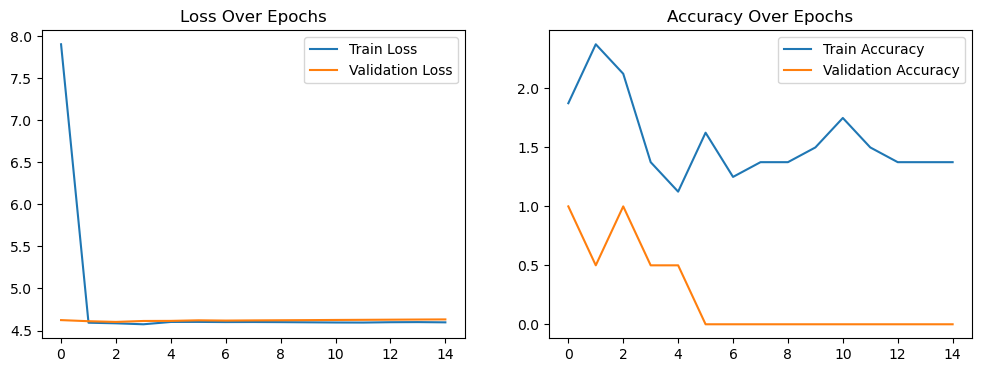

In [608]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()